In [3]:
# import packages
# load data
# define model
# define loss function
# def training loop
# def inference
# def hyperparameter

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import lightning.pytorch as pl
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

In [3]:
# define activation function
class Swish(nn.Module):
    def forward(self,x):
        return x * torch.sigmoid(x)

class Sigmoid(nn.Module):
    def forward(self,x):
        return torch.sigmoid(x)

class ReLU(nn.Module):
    def forward(self,x):
        return torch.relu(x)

In [93]:
# define model:
# model list :
# 1. joint energy based model
# 2. energy based model
class JointEnergyBasedModel(nn.Module):
    def __init__(self,img_shape,hidden_features,num_classes):
        super(JointEnergyBasedModel,self).__init__()
        self.img_shape = img_shape
        c_hid1 = hidden_features // 2
        c_hid2 = hidden_features
        c_hid3 = hidden_features * 2
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1,c_hid1,kernel_size = 5, stride = 2, padding = 4),
            Swish(),
            nn.Conv2d(c_hid1,c_hid2,kernel_size = 3, stride = 2, padding = 1),
            Swish(),
            nn.Conv2d(c_hid2,c_hid3,kernel_size = 3, stride = 2, padding = 1),
            Swish(),
            nn.Conv2d(c_hid3,c_hid3,kernel_size = 3, stride = 2, padding = 1),
            Swish(),
            nn.Flatten()
        )
        self.fc_layers = nn.Linear(c_hid3 * 4, num_classes)
        self.device = "cuda:0"
        
    def forward(self,x):
        x = self.cnn_layers(x)
        logits = self.fc_layers(x)
        energy = - torch.logsumexp(logits,dim = -1)
        return energy, logits

    def unconditional_sampling(self,num_steps,start_point,epsilon):
        # sample with MCMC
        if start_point is None:
            start_point = torch.randn(self.img_shape, requires_grad = True, device=self.device)
        else:
             start_point.requires_grad = True
        
        start_point.data.clamp_(min=-1.0, max=1.0)
        sample_list = [start_point]
        with torch.no_grad():
            energy_list = [self(start_point)[0].detach()]
        for i in range(num_steps):
            energy,logits = self(start_point)
            energy.sum().backward()
            start_point.grad.data.clamp_(-0.03, 0.03)
            #start_point = start_point - pow(epsilon,2) / 2 * start_point.grad + epsilon * torch.randn_like(start_point)
            start_point = start_point - 10 * start_point.grad.data + torch.randn_like(start_point).normal_(mean=0.0, std=0.005)
            start_point = start_point.detach().requires_grad_(True)
            start_point.data.clamp_(min=-1.0, max=1.0)
            sample_list.append(start_point.clone())
            energy_list.append(energy.detach())
        
        return start_point,sample_list,energy_list

    def conditional_sampling(self,num_steps,start_point,target_class,epsilon):
        # sample with MCMC
        if start_point is None:
            start_point = torch.randn(self.img_shape,requires_grad = True, device=self.device)
        else:
            start_point.requires_grad = True
        start_point.data.clamp_(min=-1.0, max=1.0)
        sample_list = [start_point]
        with torch.no_grad():
            energy_list = [self(start_point)[0].detach()]
        for i in range(num_steps):
            energy,logits = self(start_point)
            logits[::,target_class].backward()
            start_point.grad.data.clamp_(-0.03, 0.03)
            start_point = start_point - pow(epsilon,2) / 2 * start_point.grad + epsilon * torch.randn_like(start_point)
            start_point = start_point.detach().requires_grad_(True)
            start_point.data.clamp_(min=-1.0, max=1.0)
            sample_list.append(start_point)
            energy_list.append(energy.detach())
        
        return start_point,sample_list,energy_list

In [85]:
# define pytorch lightning model (trainer)
class PL_JointEnergyBasedModel(pl.lightning.LightningModule):
    def __init__(self,model,method,num_steps,num_samples,start_point,target_class,epsilon):
        super(PL_JointEnergyBasedModel,self).__init__(
        )
        self.model = model
        self.method = method # training method including CD, PCD, SM, DSM, SSM, NEC etc.
        self.num_steps = num_steps
        self.num_samples = num_samples
        self.start_point = start_point
        self.target_class = target_class
        self.epsilon = epsilon

    def forward(self,x):
        return self.model(x)

    def training_step(self,batch,batch_idx):
        pass

    def validation_step(self,batch,batch_idx):
        pass
    
    def test_step(self,batch,batch_idx):
        pass
    
    def configure_optimizers(self):
        pass
    
    def on_train_epoch_start(self):
        pass

    def on_validation_epoch_start(self):
        pass

    def on_test_epoch_start(self):
        pass

    def on_train_epoch_end(self):
        pass

    def on_validation_epoch_end(self):
        pass
    
    def on_test_epoch_end(self):
        pass
    

In [94]:
# definie CD training method

def MLE_training(model,train_loader,val_loader,test_loader,num_epochs,batch_size,device,num_steps,num_samples,start_point,target_class,epsilon):
    pass

def CD_training(model,optimizer,train_loader,val_loader,test_loader,num_epochs,device,num_steps,epsilon,alpha):
    cross_entropy_loss = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()

        for real_imgs, labels in train_loader:

            optimizer.zero_grad()

            real_imgs, labels = real_imgs.to(device), labels.to(device)
            
            # sample fake images with k steps of langevin dynamics
            #fake_imgs , _ , _ = model.unconditional_sampling(num_steps, real_imgs + 0.005 * torch.randn_like(real_imgs),epsilon)

            fake_imgs , _ , _ = model.unconditional_sampling(num_steps, 0.005 * torch.randn_like(real_imgs),epsilon)
            # calculate the gradient of real images
            energy_real, logits_real = model(real_imgs)
            # calculate the gradient of fake images
            energy_fake, logits_fake = model(fake_imgs)

            reg_loss = alpha * (energy_real ** 2 + energy_fake ** 2).mean()

            loss = energy_fake.mean() - energy_real.mean() + cross_entropy_loss(logits_real,labels) + reg_loss

            loss.backward()

            optimizer.step()

        model.eval()
        val_loss = 0
        total_energy_real = 0
        total_energy_fake = 0
        acc_list = []

        for real_imgs, labels in val_loader:

                
            real_imgs, labels = real_imgs.to(device), labels.to(device)

            fake_imgs , _ , _ = model.unconditional_sampling(num_steps, real_imgs + 0.01 * torch.randn_like(real_imgs),epsilon)

            energy_real, logits_real = model(real_imgs)

            energy_fake, logits_fake = model(fake_imgs)
            
            reg_loss = alpha * (energy_real ** 2 + energy_fake ** 2).mean()

            loss = energy_fake.mean() - energy_real.mean() + cross_entropy_loss(logits_real,labels) + reg_loss

            val_loss += loss.item()

            total_energy_real += energy_real.sum().item()
            total_energy_fake += energy_fake.sum().item()

            acc_list.append(torch.argmax(logits_real,dim = -1) == labels)
        
        print(f"Epoch {epoch+1} : val loss: {val_loss/len(val_loader)}")
        print(f"Epoch {epoch+1} : energy_real: {total_energy_real/len(val_loader)}")
        print(f"Epoch {epoch+1} : energy_fake: {total_energy_fake/len(val_loader)}")
        print(f"Epoch {epoch+1} : acc: {torch.cat(acc_list).float().mean()}")
        
def PCD_training(model,num_steps,num_samples,start_point,target_class,epsilon):

    pass

def CD_replay_buffer_training(model,optimizer,train_loader,val_loader,test_loader,num_epochs,device,num_steps,epsilon,alpha):
    cross_entropy_loss = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()

        for real_imgs, labels in train_loader:

            optimizer.zero_grad()

            real_imgs, labels = real_imgs.to(device), labels.to(device)
            
            # sample fake images with k steps of langevin dynamics
            fake_imgs , _ , _ = model.unconditional_sampling(num_steps, real_imgs + 0.01 * torch.randn_like(real_imgs),epsilon)

            # calculate the gradient of real images
            energy_real, logits_real = model(real_imgs)
            # calculate the gradient of fake images
            energy_fake, logits_fake = model(fake_imgs)

            reg_loss = alpha * (energy_real ** 2 + energy_fake ** 2).mean()

            loss = energy_fake.mean() - energy_real.mean() + cross_entropy_loss(logits_real,labels) + reg_loss

            loss.backward()

            optimizer.step()

        model.eval()
        val_loss = 0
        total_energy_real = 0
        total_energy_fake = 0
        acc_list = []

        for real_imgs, labels in val_loader:

                
            real_imgs, labels = real_imgs.to(device), labels.to(device)

            fake_imgs , _ , _ = model.unconditional_sampling(num_steps, real_imgs + 0.01 * torch.randn_like(real_imgs),epsilon)

            energy_real, logits_real = model(real_imgs)

            energy_fake, logits_fake = model(fake_imgs)
            
            reg_loss = alpha * (energy_real ** 2 + energy_fake ** 2).mean()

            loss = energy_fake.mean() - energy_real.mean() + cross_entropy_loss(logits_real,labels) + reg_loss

            val_loss += loss.item()

            total_energy_real += energy_real.sum().item()
            total_energy_fake += energy_fake.sum().item()

            acc_list.append(torch.argmax(logits_real,dim = -1) == labels)
        
        print(f"Epoch {epoch+1} : val loss: {val_loss/len(val_loader)}")
        print(f"Epoch {epoch+1} : energy_real: {total_energy_real/len(val_loader)}")
        print(f"Epoch {epoch+1} : energy_fake: {total_energy_fake/len(val_loader)}")
        print(f"Epoch {epoch+1} : acc: {torch.cat(acc_list).float().mean()}")

def SM_training(model,num_steps,num_samples,start_point,target_class,epsilon):
    
    pass

def DSM_training(model,num_steps,num_samples,start_point,target_class,epsilon):
    pass

def SSM_training(model,num_steps,num_samples,start_point,target_class,epsilon):
    pass

def NEC_training(model,num_steps,num_samples,start_point,target_class,epsilon):
    pass


In [95]:
# set parameters
img_shape = (1, 28, 28)
batch_size = 128
num_classes = 10
hidden_features = 32
num_steps = 10
num_samples = 1
start_point = None
target_class = None
epsilon = 0.01
lr = 0.001
beta1 = 0.9
beta2 = 0.999
epochs = 10

In [96]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])

train_dataset = datasets.MNIST(root="/work/home/maben/project/blue_whale_lab/projects/pareto_ebm/datasets", train=True, transform=transform, download=True)
val_dataset = datasets.MNIST(root="/work/home/maben/project/blue_whale_lab/projects/pareto_ebm/datasets", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [97]:
print("length of train_dataset:",len(train_dataset))
print("length of val_dataset:",len(val_dataset))

length of train_dataset: 60000
length of val_dataset: 10000


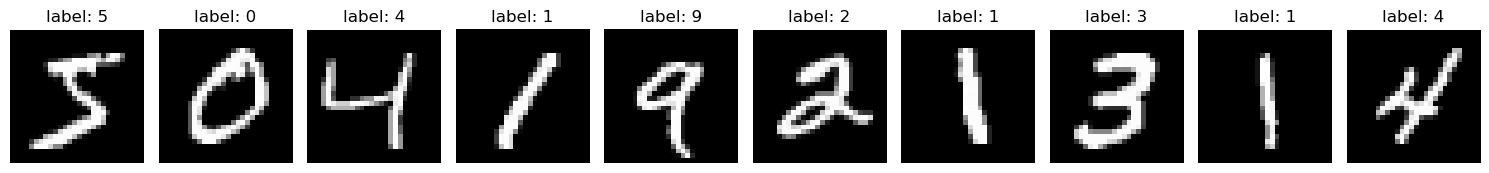

In [98]:
# display some images
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 3))  # 调整图像大小，宽度更大以适应10列
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_dataset[i][0].squeeze(), cmap='gray')
    plt.axis('off')  # 隐藏坐标轴
    plt.title(f"label: {train_dataset[i][1]}")
plt.tight_layout()  # 自动调整子图间距
plt.show()

In [99]:
model = JointEnergyBasedModel(img_shape,hidden_features,num_classes).to("cuda:0")
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)

In [103]:
CD_training_with_replay_buffer_sampler(model,optimizer,train_loader,val_loader,val_loader,5,"cuda:0",60,0.01,0.1)

[Sampler] Epoch 1 : val loss: 154058195.64556962
[Sampler] Epoch 1 : energy_real: -8215.941524650478
[Sampler] Epoch 1 : energy_fake: -4916243.217563291
[Sampler] Epoch 1 : acc: 0.11629999428987503
[Sampler] Epoch 2 : val loss: 143576852.35443038
[Sampler] Epoch 2 : energy_real: 333.9695171887362
[Sampler] Epoch 2 : energy_fake: -4679781.224683545
[Sampler] Epoch 2 : acc: 0.10740000009536743
[Sampler] Epoch 3 : val loss: 142076404.15189874
[Sampler] Epoch 3 : energy_real: 1518.7467153042178
[Sampler] Epoch 3 : energy_fake: -4641759.223892405
[Sampler] Epoch 3 : acc: 0.10359999537467957
[Sampler] Epoch 4 : val loss: 157678730.32911393
[Sampler] Epoch 4 : energy_real: 3410.0186783030063
[Sampler] Epoch 4 : energy_fake: -4892284.107594937
[Sampler] Epoch 4 : acc: 0.10199999809265137
[Sampler] Epoch 5 : val loss: 155422081.01265824
[Sampler] Epoch 5 : energy_real: 940.200459250921
[Sampler] Epoch 5 : energy_fake: -4820898.286392405
[Sampler] Epoch 5 : acc: 0.10209999978542328


In [100]:
CD_training(model,optimizer,train_loader,val_loader,val_loader,5,"cuda:0",60,0.01,0.1)

Epoch 1 : val loss: 193567904.81012657
Epoch 1 : energy_real: -16686.518931714796
Epoch 1 : energy_fake: -5562215.143987342
Epoch 1 : acc: 0.17099998891353607
Epoch 2 : val loss: 288480768.8101266
Epoch 2 : energy_real: -578570.8679291931
Epoch 2 : energy_fake: -6767223.125
Epoch 2 : acc: 0.13379999995231628
Epoch 3 : val loss: 133316242.73417722
Epoch 3 : energy_real: -78053.66913382614
Epoch 3 : energy_fake: -4550643.13449367
Epoch 3 : acc: 0.13419999182224274
Epoch 4 : val loss: 107100647.59493671
Epoch 4 : energy_real: -57630.18251520471
Epoch 4 : energy_fake: -4068489.148734177
Epoch 4 : acc: 0.14259999990463257
Epoch 5 : val loss: 127640337.51898734
Epoch 5 : energy_real: -98803.91957884197
Epoch 5 : energy_fake: -4420160.409018988
Epoch 5 : acc: 0.1184999942779541


In [185]:
def CD_training_with_replay_buffer(
    model, optimizer, train_loader, val_loader, test_loader, num_epochs, device, 
    num_steps, epsilon, alpha, buffer_size=10000
):
    cross_entropy_loss = torch.nn.CrossEntropyLoss()

    # 1. 初始化 replay buffer
    # 设定 buffer 为 real_imgs 的 shape
    buffer_shape = (buffer_size, ) + next(iter(train_loader))[0].shape[1:]
    replay_buffer = torch.randn(buffer_shape, device=device)

    buffer_ptr = 0

    def fetch_from_buffer(batch_size):
        idx = torch.randint(0, buffer_size, (batch_size,), device=device)
        return replay_buffer[idx], idx

    def update_buffer(samples, idx):
        replay_buffer[idx] = samples.detach()

    for epoch in range(num_epochs):
        model.train()

        for real_imgs, labels in train_loader:

            optimizer.zero_grad()
            real_imgs, labels = real_imgs.to(device), labels.to(device)
            batch_size = real_imgs.size(0)

            # ---- Replay Buffer采样 ----
            # 2. 从buffer取 batch_size 个初始负样本
            fake_init, buffer_idx = fetch_from_buffer(batch_size)
            # 3. Langevin 采样生成fake_imgs
            fake_imgs, _, _ = model.unconditional_sampling(num_steps, fake_init, epsilon)
            # 4. 更新buffer
            update_buffer(fake_imgs, buffer_idx)

            # --- 损失计算 ---
            energy_real, logits_real = model(real_imgs)
            energy_fake, logits_fake = model(fake_imgs)

            reg_loss = alpha * (energy_real ** 2 + energy_fake ** 2).mean()

            loss = energy_fake.mean() - energy_real.mean() + cross_entropy_loss(logits_real, labels) + reg_loss

            loss.backward()
            optimizer.step()

        # ---- Validation ----
        model.eval()
        val_loss = 0
        total_energy_real = 0
        total_energy_fake = 0
        acc_list = []

        for real_imgs, labels in val_loader:
            real_imgs, labels = real_imgs.to(device), labels.to(device)
            batch_size = real_imgs.size(0)

            # 验证时同样用 buffer 采样
            fake_init, buffer_idx = fetch_from_buffer(batch_size)
            fake_imgs, _, _ = model.unconditional_sampling(num_steps, fake_init, epsilon)
            update_buffer(fake_imgs, buffer_idx)

            energy_real, logits_real = model(real_imgs)
            energy_fake, logits_fake = model(fake_imgs)

            reg_loss = alpha * (energy_real ** 2 + energy_fake ** 2).mean()

            loss = energy_fake.mean() - energy_real.mean() + cross_entropy_loss(logits_real, labels) + reg_loss

            val_loss += loss.item()
            total_energy_real += energy_real.sum().item()
            total_energy_fake += energy_fake.sum().item()
            acc_list.append(torch.argmax(logits_real, dim=-1) == labels)
        
        print(f"Epoch {epoch+1} : val loss: {val_loss/len(val_loader)}")
        print(f"Epoch {epoch+1} : energy_real: {total_energy_real/len(val_loader)}")
        print(f"Epoch {epoch+1} : energy_fake: {total_energy_fake/len(val_loader)}")
        print(f"Epoch {epoch+1} : acc: {torch.cat(acc_list).float().mean()}")
